In [218]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle

# SKLEARN
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [219]:
# CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [220]:
## OPEN CSV
lots = pd.read_csv('./models/catalogo_das_artes_lots.csv')
print('Lots found:', lots.shape[0])

Lots found: 1953


In [221]:
## ADD NEWLY EXTRACTED LOTS

# merge lots df with catalogo_das_artes_lots.csv
new_lots = pd.read_csv('../clean-files/catalogo_das_artes_artworks_info.csv', index_col=0)
# bring 2 dfs together keeping all columns from both
merged_lots = pd.concat([lots, new_lots], ignore_index=True)
merged_lots = pd.concat([merged_lots[merged_lots['url'].isna()], merged_lots.drop_duplicates(subset=['url'])], ignore_index=True)

lots = merged_lots

In [222]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  545


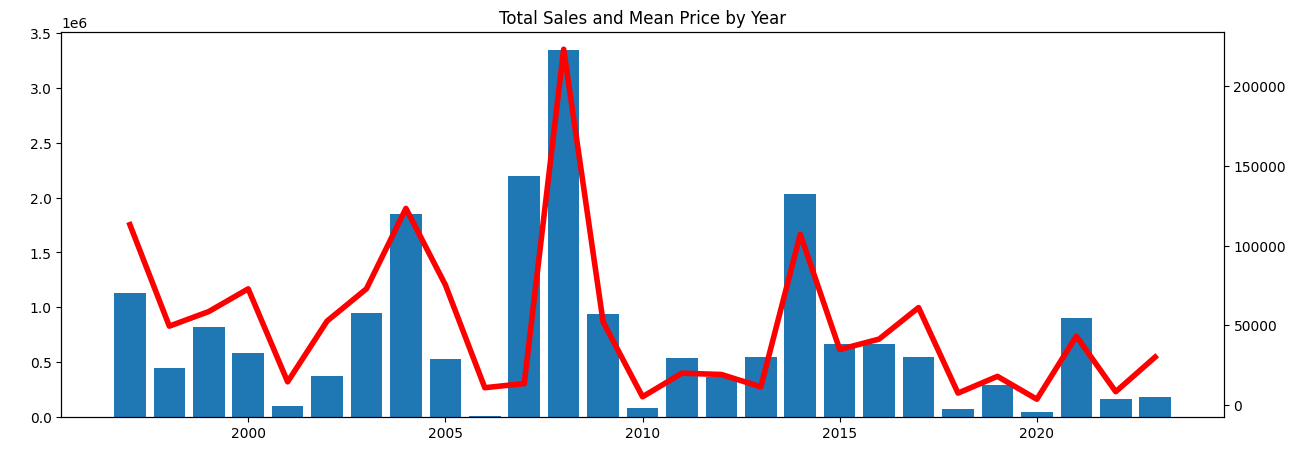

In [223]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
sales = pd.DataFrame(sold_lots.groupby('Year of sale')['Price (BRL)'].sum())
sales['Total Sales'] = sold_lots.groupby('Year of sale')['Price (BRL)'].sum()
sales['Mean Price'] = sold_lots.groupby('Year of sale')['Price (BRL)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [224]:
# TOP ARTISTS BY SALES COUNT
print('top artists by sales:')
print(sold_lots['Artist'].value_counts().head(5))

print('')

# TOP ARTISTS BY SALES VALUE
print('top artists by sales value:')
print(sold_lots.groupby('Artist')['Price (BRL)'].sum().sort_values(ascending=False).head(5))

top artists by sales:
Artist
Victor Vasarely             130
Candido Portinari           100
Vicente do Rego Monteiro     51
Marc Chagall                 48
Di Cavalcanti                16
Name: count, dtype: int64

top artists by sales value:
Artist
Candido Portinari           7606861.0
Vicente do Rego Monteiro    4255390.0
Di Cavalcanti               2343950.0
Victor Vasarely             1371490.0
Ant                          641990.0
Name: Price (BRL), dtype: float64


In [225]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (BRL)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 130 lots for Victor Vasarely


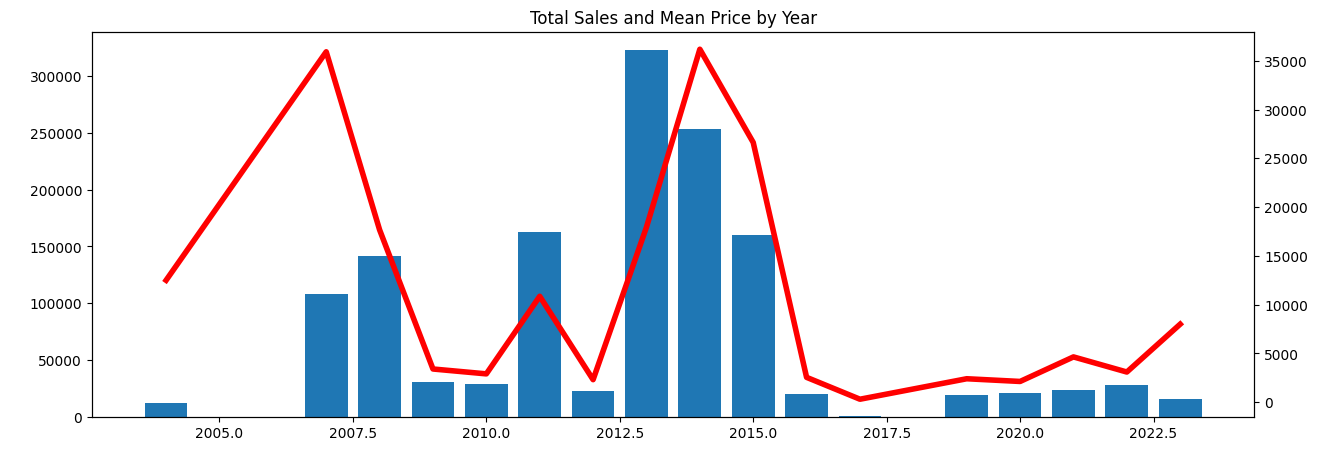

In [226]:
artist_name = 'Victor Vasarely'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (BRL)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (BRL)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (BRL)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [227]:
## FIT PRICE MODELS

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

lots_to_model = lots[['Artist', 'Width (cm)', 'Height (cm)', 'Year of sale', 'Price (BRL)', 'Technique_fix']].dropna()

print(lots_to_model.shape)

X = lots_to_model.drop(['Price (BRL)'], axis=1)
y = lots_to_model['Price (BRL)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=['Artist', 'Technique_fix'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Artist', 'Technique_fix'], drop_first=True)

# add to X_test all columns that are in X_train but not in X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

# remove from x_test all columns that are in X_test but not in X_train
for column in X_test.columns:
    if column not in X_train.columns:
        X_test.drop(column, axis=1, inplace=True)

# sort columns alphabetically
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

# function that fits all models and put metrics into a dataframe
# the function returns the dataframe and a dictionary with the models
def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                             index=['R2', 'RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [r2, rmse, mae]

    return models_df, models

models_df, models = fit_models(X_train, y_train, X_test, y_test)

models_df

(1749, 6)


,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
R2,0.059600,-1.227676,0.001708,0.436519
RMSE,92463.350274,142311.294351,95266.906067,71573.590800
MAE,52678.138294,31373.053651,25672.578376,25083.139955


In [228]:
## SAVE LOCALLY MODEL AND X_TEST

# save rf model to models
rf_model = models['Random Forest']
with open('./models/catalogo_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# save X_test as csv
X_test.to_csv('./models/catalogo_X_test.csv', index=False)
